In [2]:
import xarray as xr
import rioxarray
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# target
data_dir = Path("/scratch/sdupuis/DATA/DADA-SR/target_2")

# Get all .tif files in the folder (sorted by name)
tif_files = sorted(data_dir.glob("*.tif"))

# Open each file with xarray and store in a list
target = [xr.open_dataset(f, engine="rasterio").sel(y=slice(None, None, -1)) for f in tif_files]

print(f"Loaded {len(target)} datasets.")

Loaded 8 datasets.


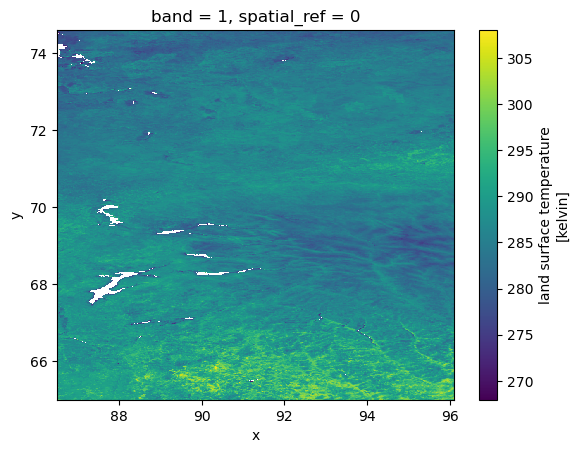

In [4]:
target[5]['band_data'].plot()

In [37]:
# quit butterly 
data_dir = Path("/scratch/sdupuis/DATA/DADA-SR/output_2/")

# Get all .tif files in the folder (sorted by name)
#10_image_fiery-waterfall_europe.tif
tif_files = sorted(data_dir.glob("*quiet-butterfly*.tif"))
print(tif_files)

# Open each file with xarray and store in a list
fiery_waterfall = [xr.open_dataset(f, engine="rasterio").sel(y=slice(None, None, -1)) for f in tif_files]

print(f"Loaded {len(fiery_waterfall)} datasets.")

[PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/01_canada_group_2_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/02_alaska_group_3_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/03_mexico_group_1_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/04_greenland_group_4_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/05_siberia_lon50_group_7_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/06_siberia_high_lat_group_8_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/07_sib_lon100_group_5_quiet-butterfly-87_v11.0_round2.tif'), PosixPath('/scratch/sdupuis/DATA/DADA-SR/output_2/10_europe_group_6_quiet-butterfly-87_v11.0_round2.tif')]
Loaded 8 datasets.


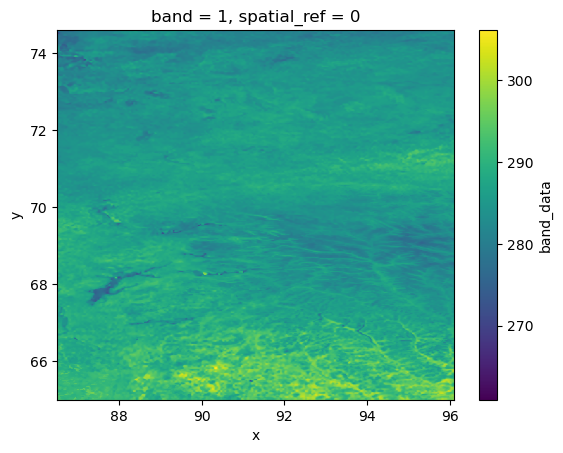

In [38]:
fiery_waterfall[5]['band_data'].plot()

In [39]:
# Force same coordinate names if they differ, fiery waterfall
datasets = [ds.rename({"x": "lon", "y": "lat"}) if "x" in ds.dims else ds
            for ds in target]
evaluation = [ds.rename({"x": "lon", "y": "lat"}) if "x" in ds.dims else ds
              for ds in fiery_waterfall]

# Reverse latitude if needed
datasets = [ds.sel(lat=slice(None, None, -1)) if ds.lat[0] > ds.lat[-1] else ds for ds in datasets]


mae_list = []
mse_list = []
rmse_list = []
file_names = []

for idx, (dsA, dsB) in enumerate(zip(datasets, evaluation)):
    # Ensure consistent lat ordering
    if dsA.lat[0] > dsA.lat[-1]:
        dsA = dsA.sel(lat=slice(None, None, -1))
    if dsB.lat[0] > dsB.lat[-1]:
        dsB = dsB.sel(lat=slice(None, None, -1))

    # Get the variable name (assume first one)
    varA = list(dsA.data_vars)[0]
    varB = list(dsB.data_vars)[0]

    daA = dsA[varA]
    daB = dsB[varB]

    # Interpolate dsB onto dsA's grid
    daB_interp = daB.interp(lat=daA.lat, lon=daA.lon)

    # Compute difference
    diff = daA - daB_interp

    # Compute MAE, MSE, RMSE (ignore NaNs)
    mae = np.nanmean(np.abs(diff.values))
    mse = np.nanmean(diff.values ** 2)
    rmse = np.sqrt(mse)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    file_names.append(f"pair_{idx}")  # replace with actual filenames if needed

# Results table
results = pd.DataFrame({
    "file": file_names,
    "MAE": mae_list,
    "MSE": mse_list,
    "RMSE": rmse_list
})

# Add mean row
mean_row = pd.DataFrame({
    "file": ["MEAN"],
    "MAE": [results["MAE"].mean()],
    "MSE": [results["MSE"].mean()],
    "RMSE": [results["RMSE"].mean()]
})

results = pd.concat([results, mean_row], ignore_index=True)

print(results)


     file       MAE       MSE      RMSE
0  pair_0  0.652023  0.800503  0.894708
1  pair_1  0.317324  0.243275  0.493229
2  pair_2  0.841493  1.330162  1.153327
3  pair_3  0.504343  0.613254  0.783105
4  pair_4  0.981908  1.757818  1.325827
5  pair_5  0.769400  1.227076  1.107734
6  pair_6  0.750175  1.101823  1.049677
7  pair_7  0.581712  0.576203  0.759080
8    MEAN  0.674797  0.956264  0.945836


### Round 2

# lunar sponge

     file       MAE       MSE      RMSE
0  pair_0  0.643896  0.787620  0.887480
1  pair_1  0.321094  0.246954  0.496944
2  pair_2  0.840110  1.326341  1.151669
3  pair_3  0.505409  0.621906  0.788610
4  pair_4  0.977547  1.743379  1.320371
5  pair_5  0.778261  1.267979  1.126046
6  pair_6  0.739552  1.078211  1.038369
7  pair_7  0.578355  0.572176  0.756423
8    MEAN  0.673028  0.955571  0.945739


# lucky wind

     file       MAE       MSE      RMSE
0  pair_0  0.653203  0.807168  0.898426
1  pair_1  0.314545  0.237260  0.487093
2  pair_2  0.838086  1.320987  1.149342
3  pair_3  0.503110  0.611889  0.782233
4  pair_4  0.980453  1.752422  1.323791
5  pair_5  0.781051  1.273681  1.128575
6  pair_6  0.751144  1.104223  1.050820
7  pair_7  0.576224  0.566602  0.752729
8    MEAN  0.674727  0.959279  0.946626

# feasible galaxy

     file       MAE       MSE      RMSE
0  pair_0  0.656637  0.808811  0.899339
1  pair_1  0.305263  0.225538  0.474908
2  pair_2  0.835426  1.312233  1.145527
3  pair_3  0.504825  0.615428  0.784492
4  pair_4  0.989695  1.787526  1.336984
5  pair_5  0.756200  1.188076  1.089989
6  pair_6  0.774217  1.158186  1.076190
7  pair_7  0.582483  0.577447  0.759900
8    MEAN  0.675593  0.959156  0.945916

# divine planet

     file       MAE       MSE      RMSE
0  pair_0  0.610203  0.723108  0.850357
1  pair_1  0.349838  0.307660  0.554671
2  pair_2  0.890329  1.498881  1.224288
3  pair_3  0.506853  0.618298  0.786319
4  pair_4  1.056142  2.049571  1.431632
5  pair_5  0.766459  1.248958  1.117568
6  pair_6  0.749818  1.104012  1.050720
7  pair_7  0.570837  0.556218  0.745800
8    MEAN  0.687560  1.013338  0.970169

# lively rain

     file       MAE       MSE      RMSE
0  pair_0  0.653586  0.804230  0.896789
1  pair_1  0.303964  0.220834  0.469929
2  pair_2  0.842513  1.333761  1.154886
3  pair_3  0.505780  0.615415  0.784484
4  pair_4  0.983599  1.766810  1.329214
5  pair_5  0.776969  1.254336  1.119972
6  pair_6  0.752844  1.109282  1.053225
7  pair_7  0.578601  0.571229  0.755797
8    MEAN  0.674732  0.959487  0.945537

# Ruby planet

     file       MAE       MSE      RMSE
0  pair_0  0.654392  0.807566  0.898646
1  pair_1  0.308305  0.223148  0.472385
2  pair_2  0.839615  1.325187  1.151168
3  pair_3  0.504392  0.614450  0.783869
4  pair_4  0.979805  1.752206  1.323709
5  pair_5  0.776177  1.261321  1.123085
6  pair_6  0.747571  1.097199  1.047473
7  pair_7  0.578076  0.570545  0.755344
8    MEAN  0.673542  0.956453  0.944460

# colorful-brooke

     file       MAE       MSE      RMSE
0  pair_0  0.669770  0.840148  0.916596
1  pair_1  0.307110  0.227694  0.477173
2  pair_2  0.843861  1.337172  1.156362
3  pair_3  0.505453  0.616557  0.785211
4  pair_4  0.990791  1.792163  1.338717
5  pair_5  0.771128  1.237129  1.112263
6  pair_6  0.760467  1.123735  1.060064
7  pair_7  0.580482  0.573969  0.757607
8    MEAN  0.678633  0.968571  0.950499

# giddy night

     file       MAE       MSE      RMSE
0  pair_0  0.670597  0.844178  0.918792
1  pair_1  0.315624  0.237977  0.487829
2  pair_2  0.839264  1.325290  1.151213
3  pair_3  0.504222  0.611824  0.782192
4  pair_4  0.981176  1.757338  1.325646
5  pair_5  0.772970  1.250139  1.118096
6  pair_6  0.750123  1.103835  1.050636
7  pair_7  0.579464  0.573003  0.756969
8    MEAN  0.676680  0.962948  0.948922

# happy firebrand

     file       MAE       MSE      RMSE
0  pair_0  0.647001  0.790676  0.889199
1  pair_1  0.318008  0.244299  0.494266
2  pair_2  0.839045  1.325395  1.151258
3  pair_3  0.509295  0.629137  0.793181
4  pair_4  0.976118  1.737917  1.318301
5  pair_5  0.788259  1.279496  1.131148
6  pair_6  0.749536  1.097560  1.047645
7  pair_7  0.577190  0.569122  0.754402
8    MEAN  0.675557  0.959200  0.947425


# fiery

     file       MAE       MSE      RMSE
0  pair_0  0.666339  0.834844  0.913698
1  pair_1  0.316161  0.242043  0.491979
2  pair_2  0.839934  1.326648  1.151802
3  pair_3  0.506042  0.621610  0.788423
4  pair_4  0.984747  1.770441  1.330579
5  pair_5  0.774889  1.254225  1.119922
6  pair_6  0.754504  1.111172  1.054122
7  pair_7  0.576712  0.567323  0.753209
8    MEAN  0.677416  0.966038  0.950466


# quiet butterfly

     file       MAE       MSE      RMSE
0  pair_0  0.652023  0.800503  0.894708
1  pair_1  0.317324  0.243275  0.493229
2  pair_2  0.841493  1.330162  1.153327
3  pair_3  0.504343  0.613254  0.783105
4  pair_4  0.981908  1.757818  1.325827
5  pair_5  0.769400  1.227076  1.107734
6  pair_6  0.750175  1.101823  1.049677
7  pair_7  0.581712  0.576203  0.759080
8    MEAN  0.674797  0.956264  0.945836

# manque source, bicubic, etc...



# firey waterfall
file       MAE        MSE      RMSE
0  pair_0  0.654192   0.808470  0.899149
1  pair_1  1.155435   2.329518  1.526276
2  pair_2  0.841290   1.330914  1.153652
3  pair_3  0.505183   0.617237  0.785645
4  pair_4  0.897582   1.947112  1.395390
5  pair_5  3.871142  33.974228  5.828742
6  pair_6  0.747241   1.100175  1.048892
7  pair_7  0.577882   0.572014  0.756316
8    MEAN  1.156243   5.334959  1.674258

# quiet butterfly 

file       MAE        MSE      RMSE
0  pair_0  0.652023   0.800504  0.894709
1  pair_1  1.157307   2.334772  1.527996
2  pair_2  0.841523   1.330248  1.153364
3  pair_3  0.504332   0.613225  0.783087
4  pair_4  0.900057   1.946345  1.395115
5  pair_5  3.887722  34.079933  5.837802
6  pair_6  0.750184   1.101850  1.049690
7  pair_7  0.581699   0.576182  0.759066
8    MEAN  1.159356   5.347882  1.675104


# balmy thunder 
file       MAE        MSE      RMSE
0  pair_0  0.640677   0.776816  0.881371
1  pair_1  1.152384   2.313801  1.521118
2  pair_2  0.837538   1.321308  1.149481
3  pair_3  0.505588   0.621200  0.788162
4  pair_4  0.898989   1.942082  1.393586
5  pair_5  3.873890  33.976588  5.828944
6  pair_6  0.743832   1.087745  1.042950
7  pair_7  0.579633   0.572717  0.756781
8    MEAN  1.154066   5.326532  1.670299

# divine planet
file       MAE        MSE      RMSE
0  pair_0  0.610190   0.723077  0.850339
1  pair_1  1.183494   2.441548  1.562545
2  pair_2  0.890319   1.498859  1.224279
3  pair_3  0.506850   0.618262  0.786296
4  pair_4  0.934448   2.023601  1.422533
5  pair_5  3.943607  34.709577  5.891483
6  pair_6  0.749855   1.104079  1.050752
7  pair_7  0.570826   0.556195  0.745785
8    MEAN  1.173699   5.459400  1.691752

# feasible galaxy

file       MAE        MSE      RMSE
0  pair_0  0.656643   0.808825  0.899347
1  pair_1  1.159866   2.345609  1.531538
2  pair_2  0.835450   1.312294  1.145554
3  pair_3  0.504825   0.615402  0.784475
4  pair_4  0.908618   1.949991  1.396421
5  pair_5  3.925493  34.534630  5.876617
6  pair_6  0.774235   1.158227  1.076210
7  pair_7  0.582479   0.577438  0.759893
8    MEAN  1.168451   5.412802  1.683757


# fine salad

file       MAE        MSE      RMSE
0  pair_0  0.666341   0.834844  0.913698
1  pair_1  1.158885   2.346253  1.531748
2  pair_2  0.839950   1.326696  1.151823
3  pair_3  0.506049   0.621632  0.788437
4  pair_4  0.899161   1.942720  1.393815
5  pair_5  3.889664  34.251163  5.852449
6  pair_6  0.754517   1.111206  1.054138
7  pair_7  0.576718   0.567332  0.753214
8    MEAN  1.161411   5.375231  1.679915


# lively rain

file       MAE        MSE      RMSE
0  pair_0  0.653581   0.804222  0.896784
1  pair_1  1.154644   2.324301  1.524566
2  pair_2  0.842517   1.333766  1.154888
3  pair_3  0.505785   0.615417  0.784485
4  pair_4  0.900738   1.937050  1.391780
5  pair_5  3.873396  33.966342  5.828065
6  pair_6  0.752847   1.109291  1.053229
7  pair_7  0.578600   0.571226  0.755795
8    MEAN  1.157764   5.332702  1.673699

# luck-wind

file       MAE        MSE      RMSE
0  pair_0  0.653203   0.807168  0.898426
1  pair_1  1.153574   2.320013  1.523159
2  pair_2  0.838086   1.320987  1.149342
3  pair_3  0.503110   0.611889  0.782233
4  pair_4  0.898108   1.946555  1.395190
5  pair_5  3.883653  34.214179  5.849289
6  pair_6  0.751144   1.104223  1.050820
7  pair_7  0.576224   0.566602  0.752729
8    MEAN  1.157138   5.361452  1.675148

# snowy-bush

file       MAE        MSE      RMSE
0  pair_0  0.651669   0.804920  0.897173
1  pair_1  1.168597   2.386003  1.544669
2  pair_2  0.834387   1.309129  1.144172
3  pair_3  0.505875   0.617692  0.785934
4  pair_4  0.913982   1.957548  1.399124
5  pair_5  3.952801  34.847288  5.903159
6  pair_6  0.776570   1.169635  1.081497
7  pair_7  0.578720   0.570958  0.755618
8    MEAN  1.172825   5.457897  1.688918

# wild paper 78

file       MAE        MSE      RMSE
0  pair_0  0.652531   0.805809  0.897669
1  pair_1  1.154342   2.329016  1.526112
2  pair_2  0.846078   1.345740  1.160060
3  pair_3  0.505021   0.615430  0.784494
4  pair_4  0.900936   1.929755  1.389156
5  pair_5  3.872022  33.878932  5.820561
6  pair_6  0.743376   1.087939  1.043043
7  pair_7  0.576133   0.566498  0.752661
8    MEAN  1.156305   5.319890  1.671719

# rubby planet 65

file       MAE        MSE      RMSE
0  pair_0  0.654389   0.807558  0.898642
1  pair_1  1.152382   2.320408  1.523289
2  pair_2  0.839627   1.325228  1.151186
3  pair_3  0.504386   0.614421  0.783850
4  pair_4  0.899637   1.944224  1.394354
5  pair_5  3.884017  34.066707  5.836669
6  pair_6  0.747557   1.097175  1.047461
7  pair_7  0.578072   0.570538  0.755340
8    MEAN  1.157509   5.343283  1.673849

# source

file       MAE        MSE      RMSE
0  pair_0  0.756935   1.056676  1.027948
1  pair_1  1.272985   2.863492  1.692186
2  pair_2  1.029148   1.955731  1.398475
3  pair_3  0.545243   0.707777  0.841295
4  pair_4  0.997230   2.243269  1.497755
5  pair_5  4.175324  36.693846  6.057545
6  pair_6  0.872301   1.423443  1.193081
7  pair_7  0.616525   0.666349  0.816302
8    MEAN  1.283211   5.951323  1.815573

# bicubic

file       MAE        MSE      RMSE
0  pair_0  0.728156   0.979410  0.989651
1  pair_1  1.236586   2.672818  1.634875
2  pair_2  0.964816   1.732651  1.316302
3  pair_3  0.525821   0.653805  0.808582
4  pair_4  0.973136   2.154080  1.467679
5  pair_5  4.079438  35.819117  5.984907
6  pair_6  0.844139   1.343243  1.158983
7  pair_7  0.602837   0.616122  0.784934
8    MEAN  1.244366   5.746406  1.768239

# happy firebrand


file       MAE        MSE      RMSE
0  pair_0  0.647044   0.790758  0.889246
1  pair_1  1.155942   2.333288  1.527510
2  pair_2  0.839059   1.325422  1.151270
3  pair_3  0.509237   0.628968  0.793075
4  pair_4  0.898238   1.955742  1.398478
5  pair_5  3.823783  33.497512  5.787704
6  pair_6  0.749561   1.097572  1.047651
7  pair_7  0.577193   0.569122  0.754402
8    MEAN  1.150007   5.274798  1.668667

# spring wave

file       MAE        MSE      RMSE
0  pair_0  0.663608   0.829492  0.910765
1  pair_1  1.156762   2.335369  1.528191
2  pair_2  0.842098   1.332680  1.154417
3  pair_3  0.504426   0.614134  0.783667
4  pair_4  0.901270   1.938725  1.392381
5  pair_5  3.886419  34.035879  5.834028
6  pair_6  0.752110   1.109269  1.053218
7  pair_7  0.580794   0.574515  0.757968
8    MEAN  1.160936   5.346258  1.676829


# lunar sponge

file       MAE        MSE      RMSE
0  pair_0  0.643899   0.787632  0.887486
1  pair_1  1.154906   2.327270  1.525539
2  pair_2  0.840111   1.326347  1.151671
3  pair_3  0.505408   0.621904  0.788609
4  pair_4  0.899498   1.939047  1.392497
5  pair_5  3.893084  34.357333  5.861513
6  pair_6  0.739554   1.078213  1.038370
7  pair_7  0.578366   0.572194  0.756435
8    MEAN  1.156853   5.376242  1.675265

In [43]:
# do for bicubic and source as well!

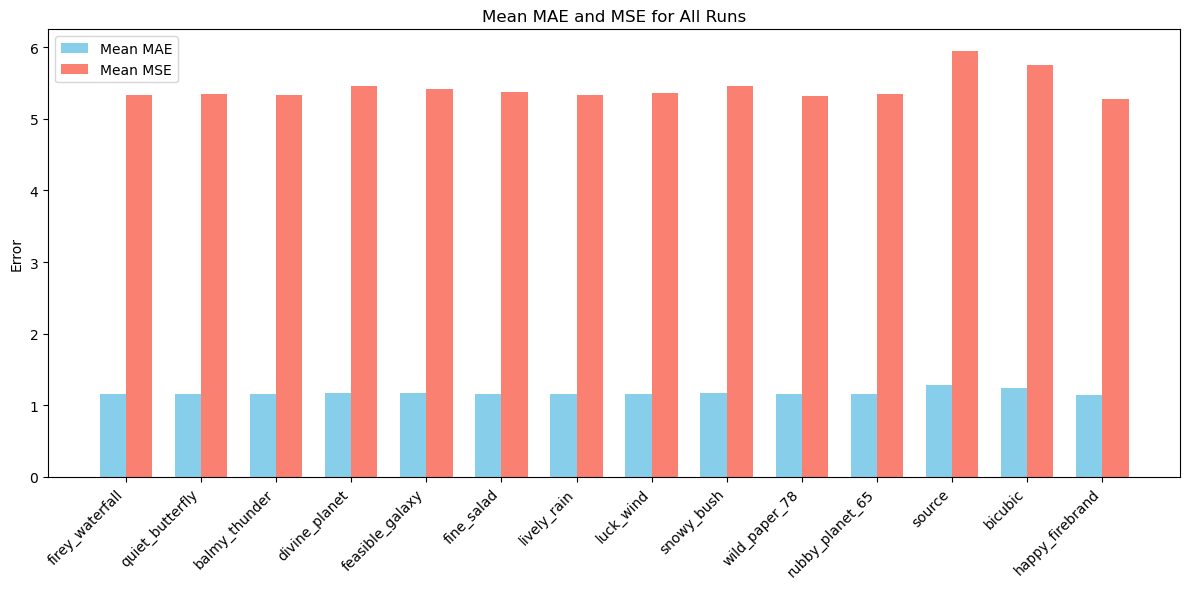

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: Replace this dictionary with your actual run mean values
runs = [
    ("firey_waterfall", 1.156243, 5.334959),
    ("quiet_butterfly", 1.159356, 5.347882),
    ("balmy_thunder", 1.154066, 5.326532),
    ("divine_planet", 1.173699, 5.459400),
    ("feasible_galaxy", 1.168451, 5.412802),
    ("fine_salad", 1.161411, 5.375231),
    ("lively_rain", 1.157764, 5.332702),
    ("luck_wind", 1.157138, 5.361452),
    ("snowy_bush", 1.172825, 5.457897),
    ("wild_paper_78", 1.156305, 5.319890),
    ("rubby_planet_65", 1.157509, 5.343283),
    ("source", 1.283211, 5.951323),
    ("bicubic", 1.244366, 5.746406),
    ("happy_firebrand", 1.150007, 5.274798)
]

# Create a DataFrame
df = pd.DataFrame(runs, columns=["run", "MAE", "MSE"])

# Set figure size
plt.figure(figsize=(12, 6))

# X positions
x = np.arange(len(df))

# Bar width
width = 0.35

# Plot MAE and MSE side by side
plt.bar(x - width/2, df["MAE"], width, label="Mean MAE", color="skyblue")
plt.bar(x + width/2, df["MSE"], width, label="Mean MSE", color="salmon")

# Labels and ticks
plt.xticks(x, df["run"], rotation=45, ha="right")
plt.ylabel("Error")
plt.title("Mean MAE and MSE for All Runs")
plt.legend()
plt.tight_layout()

plt.show()
